# A.1 : classification problem, logistic regression, impact of mutational signatures
In this notebook, we compare, for the classification problem with the logistic regression, the following configurations :
- without mutational signatures (only biomarkers from the reference article : https://doi.org/10.1158/1078-0432.CCR-20-1163)
- with only mutational signatures
- with combination of reference article biomarkers and the mutational signatures

## Table of contents

1. [No mutational signatures](#1-no-sigmut)
2. [Only mutational signatures](#2-only-sigmut)
3. [Initial biomarkers + mutational signatures](#3-not-normalized-sigmut)
4. [Evaluate performances](#4-performances)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.LogisticRegressionTrainTestManager import LogisticRegressionTrainTestManager

from utils.FeatureSelector import FeatureSelector
from utils.PreProcessor import PreProcessor

#### Set hyper-parameters

In [28]:
n_features = 5
n_epochs = 150
lr = 0.005
reg = 0.005

#### Reading and preprocessing

In [29]:
# Reading dataset
df = pd.read_excel('data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = PreProcessor.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = PreProcessor.relabel_patients(df, "Progression_1", "Time to progression (days)", t)

# Normalize initial biomarkers
features_to_normalize = ["Age at advanced disease diagnosis",
                         "CD8+ T cell score",
                         "Genome mut per mb",
                         "Exome mut per mb",
                         "CD274 expression",
                         "M1M2 expression"]

df.loc[:, features_to_normalize] = PreProcessor.normalize_data(df.loc[:, features_to_normalize])

# Extract labels
y = df["Progression_1"].to_numpy()

### 1. No mutational signatures

#### Feature selection

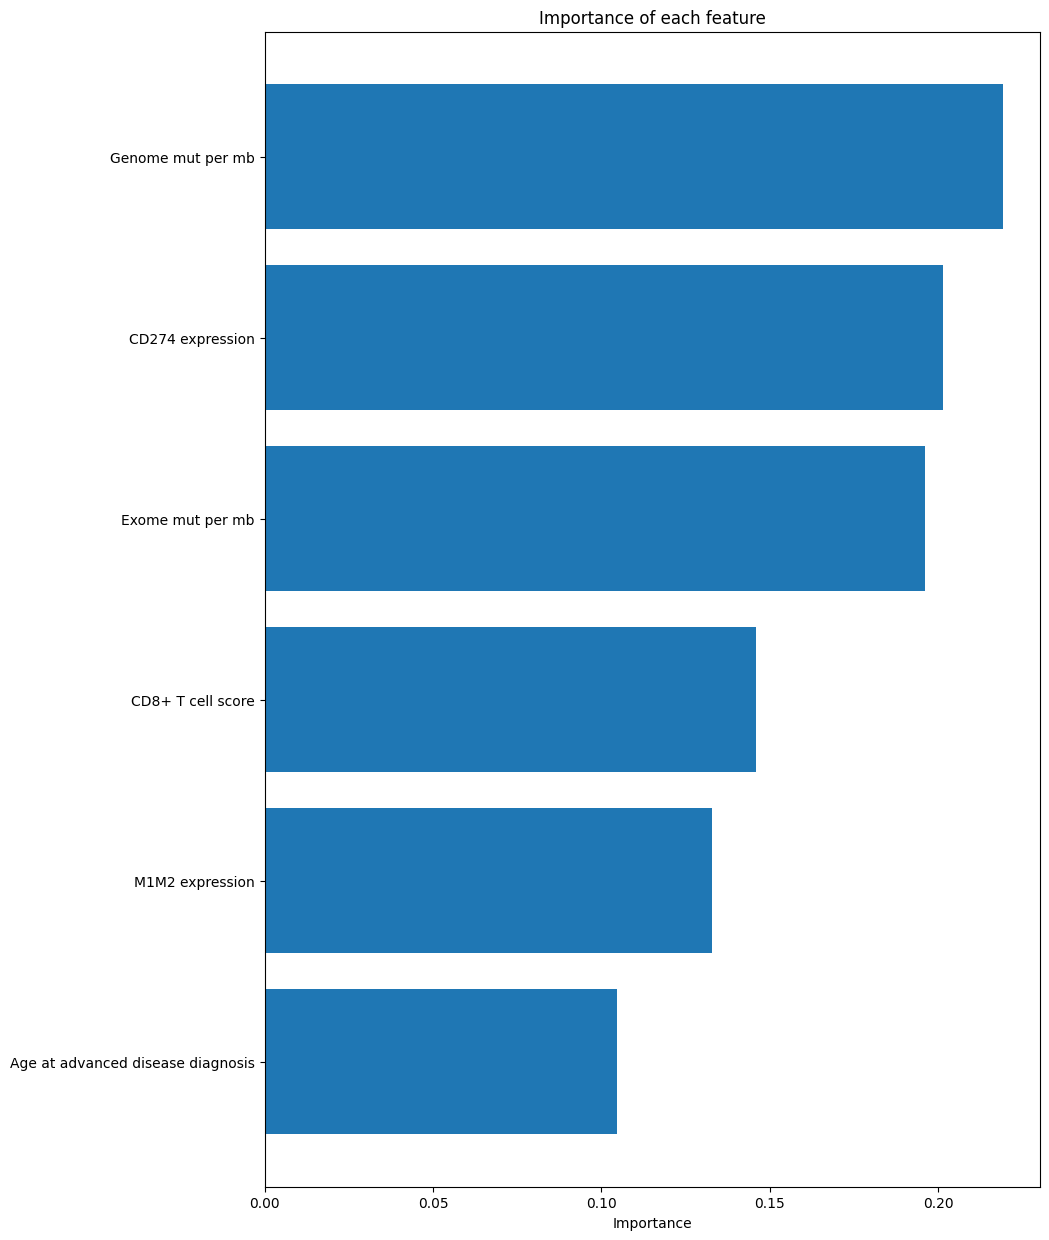

In [30]:
features_name_no_sigmut = ["Age at advanced disease diagnosis",
                           "CD8+ T cell score",
                           "Genome mut per mb",
                           "Exome mut per mb",
                           "CD274 expression",
                           "M1M2 expression"]

# Compute feature importance
features_name_no_sigmut = FeatureSelector.feature_importance(df.loc[:, features_name_no_sigmut], y, True)

# Select the most n_features important features
if n_features < len(features_name_no_sigmut):
    features_name_no_sigmut = features_name_no_sigmut[:n_features]

# Extract features
X_no_sigmut = df.loc[:, features_name_no_sigmut].to_numpy()

#### Execute the leave one out CV

In [31]:
manager_no_sigmut = LogisticRegressionTrainTestManager()
scores_no_sigmut, classes_no_sigmut, train_loss_no_sigmut, val_loss_no_sigmut = manager_no_sigmut.leave_one_out_cv(X_no_sigmut, y, n_epochs, lr, reg)

### 2. Only mutational signatures

#### Feature selection

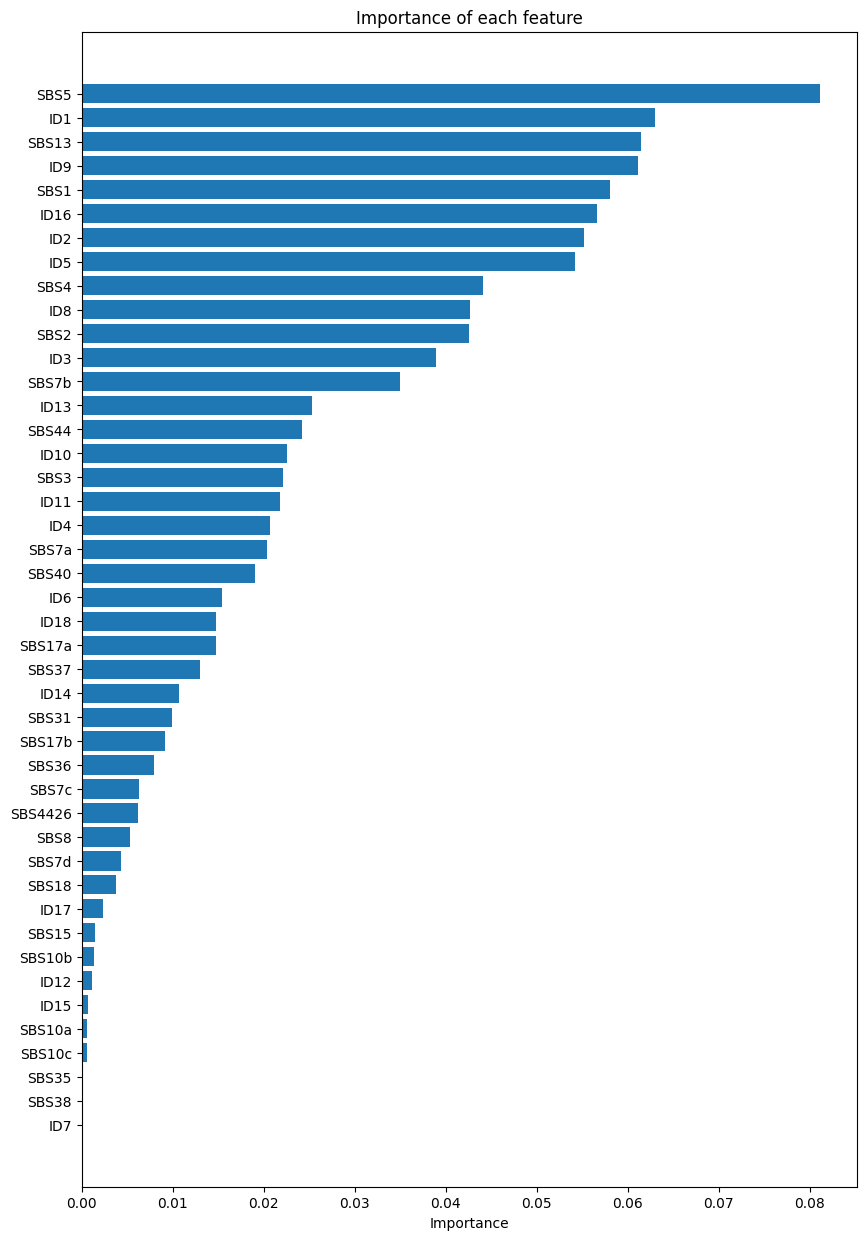

In [32]:
features_name_only_sigmut = ["SBS1",
                             "SBS2",
                             "SBS3",
                             "SBS4",
                             "SBS5",
                             "SBS7a",
                             "SBS7b",
                             "SBS7c",
                             "SBS7d",
                             "SBS8",
                             "SBS10a",
                             "SBS10b",
                             "SBS10c",
                             "SBS13",
                             "SBS15",
                             "SBS17a",
                             "SBS17b",
                             "SBS18",
                             "SBS31",
                             "SBS35",
                             "SBS36",
                             "SBS37",
                             "SBS38",
                             "SBS40",
                             "SBS44",
                             "SBS4426",
                             "ID1",
                             "ID2",
                             "ID3",
                             "ID4",
                             "ID5",
                             "ID6",
                             "ID7",
                             "ID8",
                             "ID9",
                             "ID10",
                             "ID11",
                             "ID12",
                             "ID13",
                             "ID14",
                             "ID15",
                             "ID16",
                             "ID17",
                             "ID18"]

# Compute feature importance
features_name_only_sigmut = FeatureSelector.feature_importance(df.loc[:, features_name_only_sigmut], y, True)

# Select the most n_features important features
if n_features < len(features_name_only_sigmut):
    features_name_only_sigmut = features_name_only_sigmut[:n_features]

# Extract features
X_only_sigmut = df.loc[:, features_name_only_sigmut].to_numpy()

#### Execute the leave one out CV

In [33]:
manager_only_sigmut = LogisticRegressionTrainTestManager()
scores_only_sigmut, classes_only_sigmut, train_loss_only_sigmut, val_loss_only_sigmut = manager_only_sigmut.leave_one_out_cv(X_only_sigmut, y, n_epochs, lr, reg)

### 3. Initial biomarkers + mutational signatures

#### Feature selection

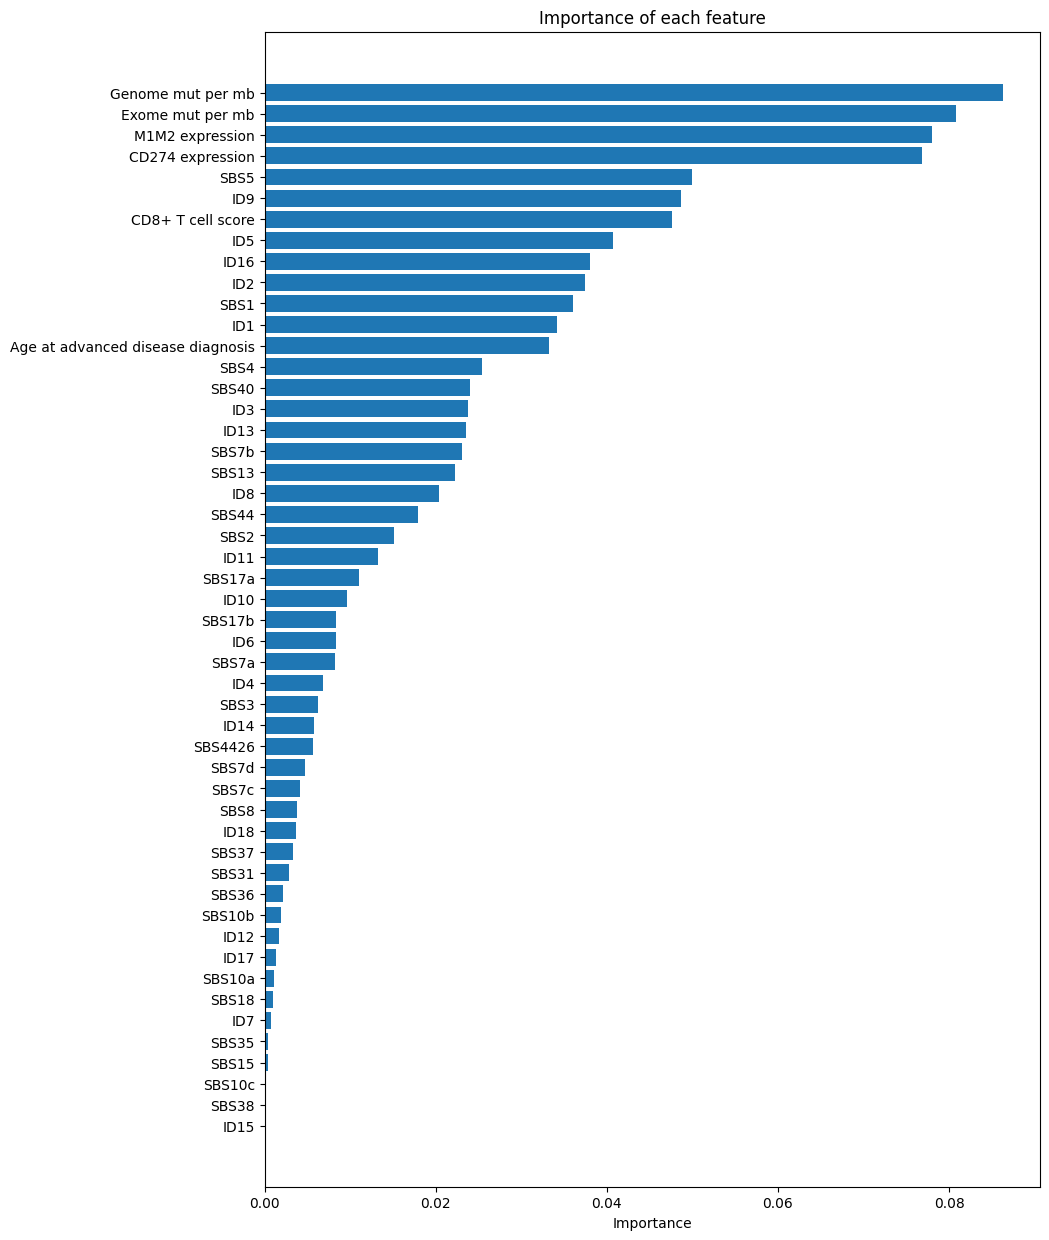

In [34]:
features_name_comb = ["Age at advanced disease diagnosis",
                      "CD8+ T cell score",
                      "Genome mut per mb",
                      "Exome mut per mb",
                      "CD274 expression",
                      "M1M2 expression",
                      "SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
features_name_comb = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb = features_name_comb[:n_features]

# Extract features
X_comb = df.loc[:, features_name_comb].to_numpy()

#### Execute the leave one out CV

In [35]:
manager_comb = LogisticRegressionTrainTestManager()
scores_comb, classes_comb, train_loss_comb, val_loss_comb = manager_comb.leave_one_out_cv(X_comb, y, n_epochs, lr, reg)

### 4. Evaluate performances

#### Classification metrics

In [36]:
# No mutational signatures
fpr_no_sigmut, tpr_no_sigmut = ClassificationMetrics.compute_roc_curve(y, scores_no_sigmut)
sensitivity_no_sigmut, specificity_no_sigmut = ClassificationMetrics.compute_sensitivity_specificity(y, classes_no_sigmut)
auc_no_sigmut = ClassificationMetrics.compute_auc(y,scores_no_sigmut)

# Only mutational signatures
fpr_only_sigmut, tpr_only_sigmut = ClassificationMetrics.compute_roc_curve(y, scores_only_sigmut)
sensitivity_only_sigmut, specificity_only_sigmut = ClassificationMetrics.compute_sensitivity_specificity(y,
classes_only_sigmut)
auc_only_sigmut = ClassificationMetrics.compute_auc(y,scores_only_sigmut)

# Initial biomarkers + mutational signatures
fpr_comb, tpr_comb = ClassificationMetrics.compute_roc_curve(y, scores_comb)
sensitivity_comb, specificity_comb = ClassificationMetrics.compute_sensitivity_specificity(y,classes_comb)
auc_comb = ClassificationMetrics.compute_auc(y,scores_comb)

invalid value encountered in scalar divide


#### SHAP values

In [37]:
# No sigmut
X_torch_no_sigmut = torch.from_numpy(X_no_sigmut).float()
explainer_no_sigmut = shap.DeepExplainer(manager_no_sigmut.model, X_torch_no_sigmut)
shap_values_no_sigmut = explainer_no_sigmut.shap_values(X_torch_no_sigmut)
expected_values_no_sigmut = explainer_no_sigmut.expected_value

# Only sigmut
X_torch_only_sigmut = torch.from_numpy(X_only_sigmut).float()
explainer_only_sigmut = shap.DeepExplainer(manager_only_sigmut.model, X_torch_only_sigmut)
shap_values_only_sigmut = explainer_only_sigmut.shap_values(X_torch_only_sigmut)
expected_values_only_sigmut = explainer_only_sigmut.expected_value

# Initial biomarkers + mutational signatures
X_torch_comb = torch.from_numpy(X_comb).float()
explainer_comb = shap.DeepExplainer(manager_comb.model, X_torch_comb)
shap_values_comb = explainer_comb.shap_values(X_torch_comb)
expected_values_comb = explainer_comb.expected_value

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


#### Plot results

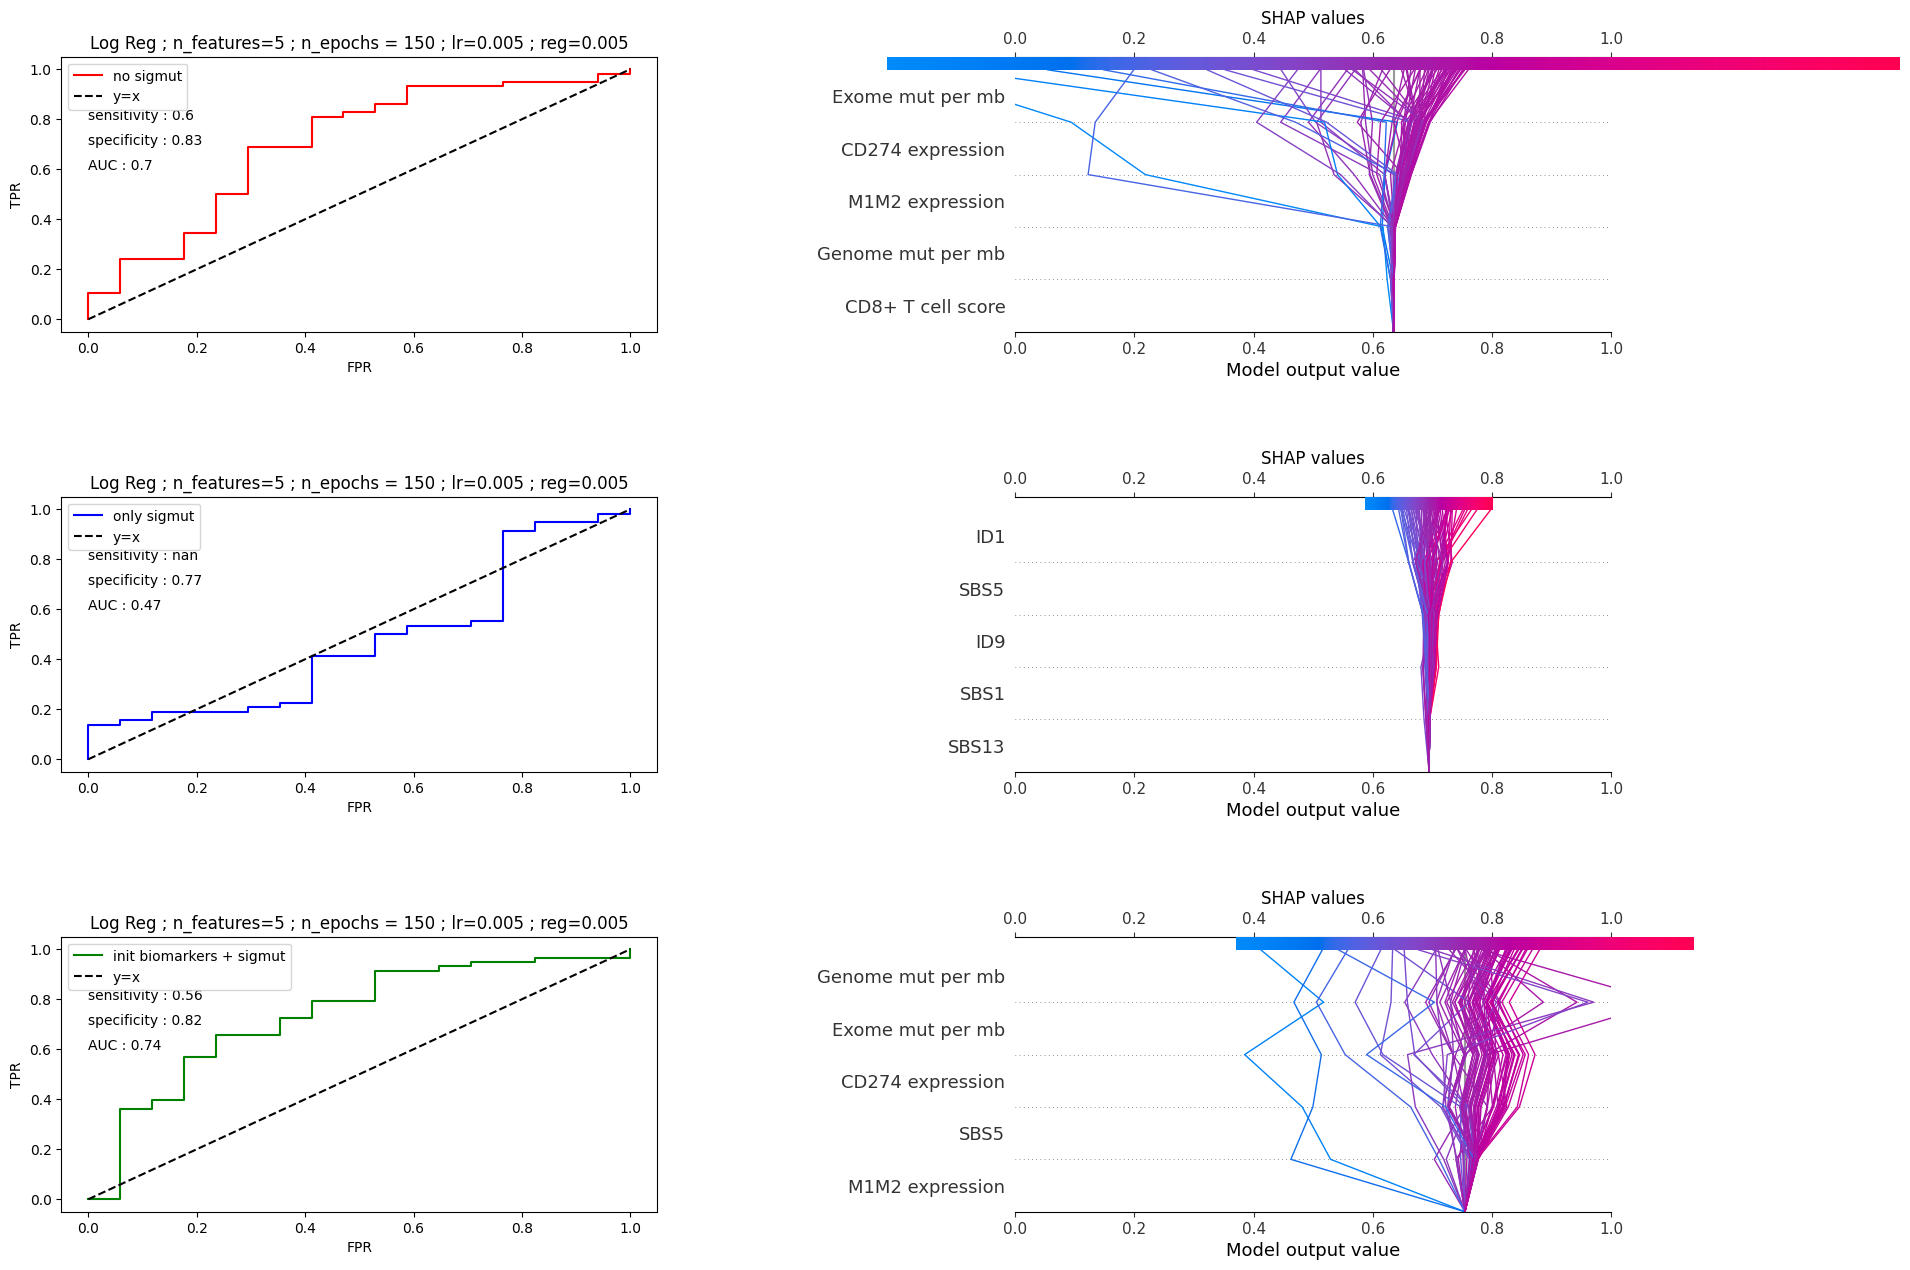

In [38]:
fig = plt.figure()
x = np.linspace(0,1,100)

# No sigmut
ax0 = fig.add_subplot(321)
ax0.plot(fpr_no_sigmut, tpr_no_sigmut, color='red',label='no sigmut')
ax0.plot(x,x,linestyle='--',color='black',label='y=x')
ax0.set_xlabel("FPR")
ax0.set_ylabel("TPR")
ax0.set_title(f"Log Reg ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg}")
ax0.text(0,0.8,f"sensitivity : {sensitivity_no_sigmut}")
ax0.text(0,0.7,f"specificity : {specificity_no_sigmut}")
ax0.text(0,0.6,f"AUC : {auc_no_sigmut}")
ax0.legend()

ax1 = fig.add_subplot(322)
shap.decision_plot(expected_values_no_sigmut, shap_values_no_sigmut, features_name_no_sigmut, show=False)
ax1.set_title("SHAP values")
ax1.set_xlim(0,1)

# Only sigmut
ax2 = fig.add_subplot(323)
ax2.plot(fpr_only_sigmut, tpr_only_sigmut, color='blue',label='only sigmut')
ax2.plot(x,x,linestyle='--',color='black',label='y=x')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.set_title(f"Log Reg ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg}")
ax2.text(0,0.8,f"sensitivity : {sensitivity_only_sigmut}")
ax2.text(0,0.7,f"specificity : {specificity_only_sigmut}")
ax2.text(0,0.6,f"AUC : {auc_only_sigmut}")
ax2.legend()

ax3 = fig.add_subplot(324)
shap.decision_plot(expected_values_only_sigmut, shap_values_only_sigmut, features_name_only_sigmut, show=False)
ax3.set_title("SHAP values")
ax3.set_xlim(0,1)

# Initial biomarkers + sigmut
ax4 = fig.add_subplot(325)
ax4.plot(fpr_comb, tpr_comb, color='green',label='init biomarkers + sigmut')
ax4.plot(x,x,linestyle='--',color='black',label='y=x')
ax4.set_xlabel("FPR")
ax4.set_ylabel("TPR")
ax4.set_title(f"Log Reg ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg}")
ax4.text(0,0.8,f"sensitivity : {sensitivity_comb}")
ax4.text(0,0.7,f"specificity : {specificity_comb}")
ax4.text(0,0.6,f"AUC : {auc_comb}")
ax4.legend()

ax5 = fig.add_subplot(326)
shap.decision_plot(expected_values_comb, shap_values_comb, features_name_comb, show=False)
ax5.set_title("SHAP values")
ax5.set_xlim(0,1)

plt.gcf().set_size_inches(20,15)
plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()

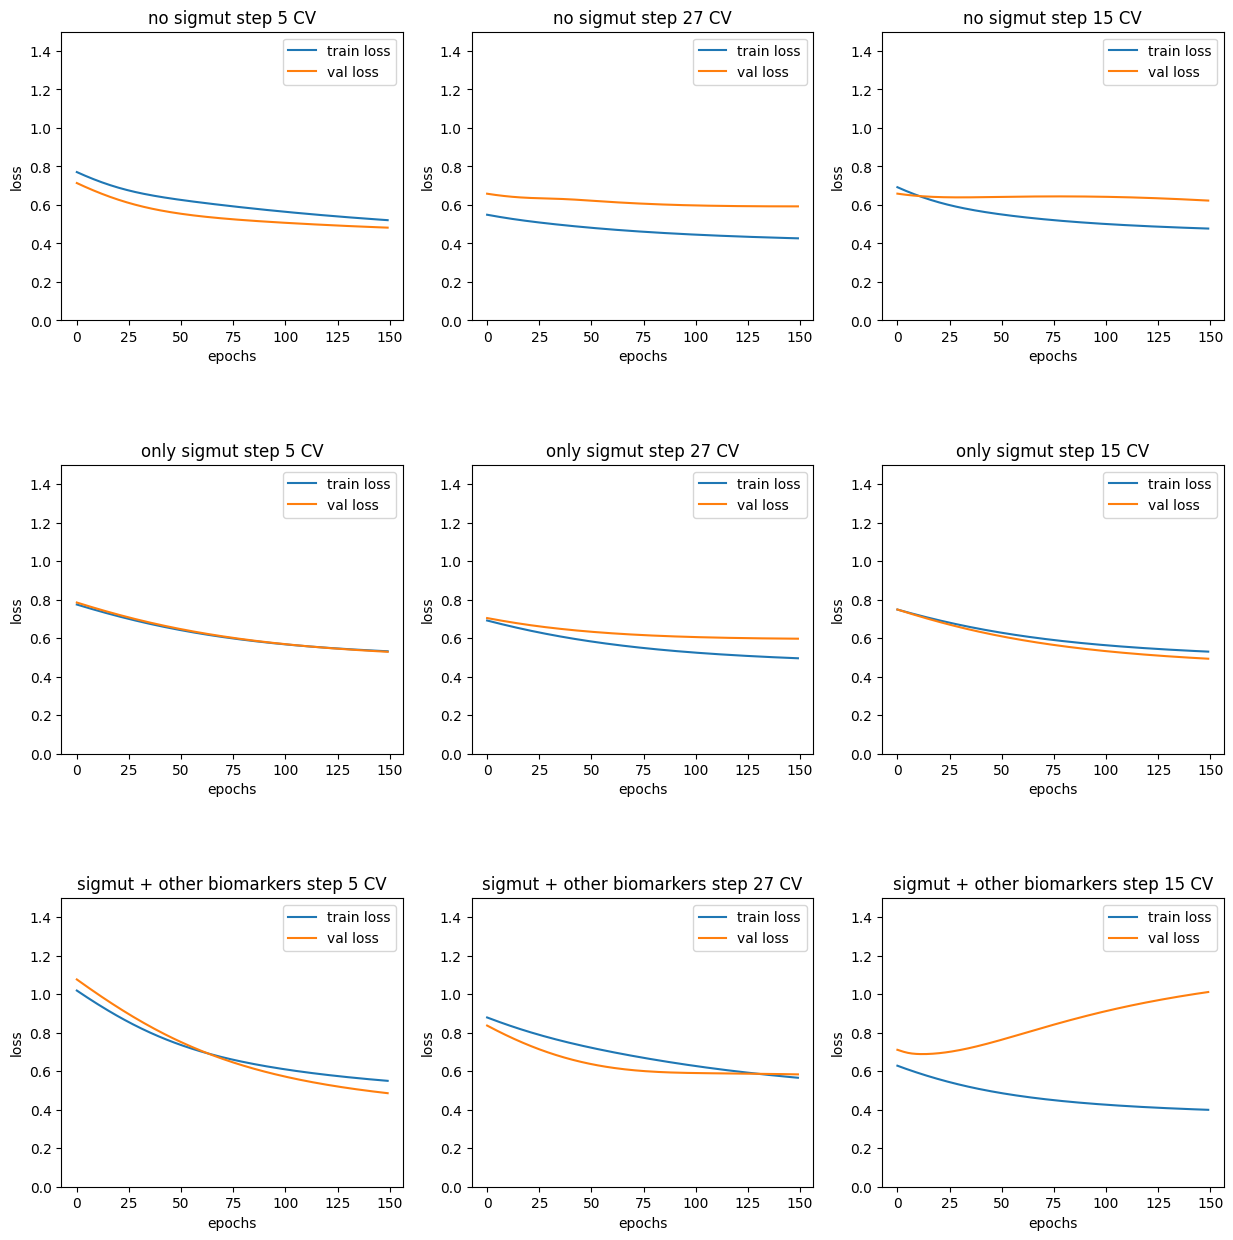

In [39]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(3,3,figsize=(15,15))

patient0 = np.random.randint(0,df.shape[0]-1)
patient1 = np.random.randint(0,df.shape[0]-1)
patient2 = np.random.randint(0,df.shape[0]-1)

# No sigmut :
ax[0,0].plot(epochs, train_loss_no_sigmut[patient0],label='train loss')
ax[0,0].plot(epochs, val_loss_no_sigmut[patient0],label='val loss')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title(f'no sigmut step {patient0} CV')
ax[0,0].set_ylim(0,1.5)
ax[0,0].legend()

ax[0,1].plot(epochs, train_loss_no_sigmut[patient1],label='train loss')
ax[0,1].plot(epochs, val_loss_no_sigmut[patient1],label='val loss')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title(f'no sigmut step {patient1} CV')
ax[0,1].set_ylim(0,1.5)
ax[0,1].legend()

ax[0,2].plot(epochs, train_loss_no_sigmut[patient2],label='train loss')
ax[0,2].plot(epochs, val_loss_no_sigmut[patient2],label='val loss')
ax[0,2].set_xlabel('epochs')
ax[0,2].set_ylabel('loss')
ax[0,2].set_title(f'no sigmut step {patient2} CV')
ax[0,2].set_ylim(0,1.5)
ax[0,2].legend()

# Only sigmut :
ax[1,0].plot(epochs, train_loss_only_sigmut[patient0],label='train loss')
ax[1,0].plot(epochs, val_loss_only_sigmut[patient0],label='val loss')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title(f'only sigmut step {patient0} CV')
ax[1,0].set_ylim(0,1.5)
ax[1,0].legend()

ax[1,1].plot(epochs, train_loss_only_sigmut[patient1],label='train loss')
ax[1,1].plot(epochs, val_loss_only_sigmut[patient1],label='val loss')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('loss')
ax[1,1].set_title(f'only sigmut step {patient1} CV')
ax[1,1].set_ylim(0,1.5)
ax[1,1].legend()

ax[1,2].plot(epochs, train_loss_only_sigmut[patient2],label='train loss')
ax[1,2].plot(epochs, val_loss_only_sigmut[patient2],label='val loss')
ax[1,2].set_xlabel('epochs')
ax[1,2].set_ylabel('loss')
ax[1,2].set_title(f'only sigmut step {patient2} CV')
ax[1,2].set_ylim(0,1.5)
ax[1,2].legend()

# Sigmut + other biomarkers :
ax[2,0].plot(epochs, train_loss_comb[patient0],label='train loss')
ax[2,0].plot(epochs, val_loss_comb[patient0],label='val loss')
ax[2,0].set_xlabel('epochs')
ax[2,0].set_ylabel('loss')
ax[2,0].set_title(f'sigmut + other biomarkers step {patient0} CV')
ax[2,0].set_ylim(0,1.5)
ax[2,0].legend()

ax[2,1].plot(epochs, train_loss_comb[patient1],label='train loss')
ax[2,1].plot(epochs, val_loss_comb[patient1],label='val loss')
ax[2,1].set_xlabel('epochs')
ax[2,1].set_ylabel('loss')
ax[2,1].set_title(f'sigmut + other biomarkers step {patient1} CV')
ax[2,1].set_ylim(0,1.5)
ax[2,1].legend()

ax[2,2].plot(epochs, train_loss_comb[patient2],label='train loss')
ax[2,2].plot(epochs, val_loss_comb[patient2],label='val loss')
ax[2,2].set_xlabel('epochs')
ax[2,2].set_ylabel('loss')
ax[2,2].set_title(f'sigmut + other biomarkers step {patient2} CV')
ax[2,2].set_ylim(0,1.5)
ax[2,2].legend()
plt.subplots_adjust(hspace=0.5)